# Importing Libraries

In [1]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 17.0 MB/s eta 0:00:00


In [2]:
import pickle 
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.stats import mode
import neurokit2 as nk
import os
from scipy.stats import skew, kurtosis


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Importing Pickle file of Subject 2

In [3]:
file_path = "/kaggle/input/wesad-full-dataset/WESAD/S2/S2.pkl"

with open(file_path, "rb") as file:
    s2 = pickle.load(file, encoding="latin1")

print(s2)


{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275],
       

## Preprocessing Subject 2
We will focus on the data from RespiBAN (chest device).
ECG, EDA, EMG, ACC, Temp, and Respiration are the key features related to stress. We will extract the HR from the ECG data and then synchronize it with the EDA, respiration, and Labels. We will extract Mean,STD,Min,Max from each feature in each window. Finally, we'll organize everything into a data frame to prepare it for input into the model.

In [4]:
s2_ecg_signal = s2["signal"]["chest"]["ECG"]
s2_eda_signal = s2["signal"]["chest"]["EDA"]
s2_resp_signal = s2["signal"]["chest"]["Resp"]
s2_emg_signal = s2["signal"]["chest"]["EMG"]
s2_temp_signal = s2["signal"]["chest"]["Temp"]
s2_labels = s2["label"]

# Flatten the data (make it 1D array)
s2_ecg_signal = s2_ecg_signal.flatten()
s2_eda_signal = s2_eda_signal.flatten()
s2_resp_signal = s2_resp_signal.flatten()
s2_emg_signal = s2_emg_signal.flatten()
s2_temp_signal = s2_temp_signal.flatten()

# Sampling Rates (All signals were sampled at 700 Hz) and Preparing window size and the number of values in each window
frequency = 700  # Hz
windows_size = 30  # Seconds
no_of_values_in_window = windows_size * frequency

# Noise Reduction
s2_ecg_cleaned = nk.ecg_clean(s2_ecg_signal, sampling_rate=frequency)

# Total number of windows in the subject
total_no_of_windows = len(s2_ecg_signal) // no_of_values_in_window

# Feature Extraction
s2_features=[]

for i in range(total_no_of_windows):      
    start = i * no_of_values_in_window
    end = start + no_of_values_in_window 

    if end > len(s2_ecg_signal):
        continue
    
    # Window Extraction
    s2_ecg_window = s2_ecg_cleaned[start:end]
    s2_eda_window = s2_eda_signal[start:end]
    s2_resp_window = s2_resp_signal[start:end]
    s2_emg_window = s2_emg_signal[start:end]
    s2_temp_window = s2_temp_signal[start:end]
    s2_label_window = s2_labels[start:end]

    # Finding R-Peaks
    s2_r_peaks, _ = signal.find_peaks(s2_ecg_window, distance=frequency*0.6, height=np.mean(s2_ecg_window))

    # Calculate HR in Beats Per Minute (BPM)
    if len(s2_r_peaks) >= 2:
        s2_rr_intervals = np.diff(s2_r_peaks) / frequency 
        s2_hr_bpm = 60 / s2_rr_intervals
    else:
        s2_hr_bpm = np.array([np.nan])  # Put NaN instead of blank

    # Temp Slope
    x_time_s2 = np.arange(len(s2_temp_window))
    s2_temp_slope = np.polyfit(x_time_s2, s2_temp_window, 1)[0]

    # Arrange features of each window in list of dictionaries
    s2_features.append({
        "Subject_ID": 's2',
        "Mean_HR": np.nanmean(s2_hr_bpm),
        "Median_HR": np.nanmedian(s2_hr_bpm),
        "Skewness_HR": skew(s2_hr_bpm, nan_policy='omit'),
        "Kurtosis_HR": kurtosis(s2_hr_bpm, nan_policy='omit'),
        "STD_HR": np.nanstd(s2_hr_bpm),
        "Min_HR": np.nanmin(s2_hr_bpm),
        "Max_HR": np.nanmax(s2_hr_bpm),
        "HRV": np.nanmax(s2_hr_bpm) - np.nanmin(s2_hr_bpm),
        "Mean_EDA": np.nanmean(s2_eda_window),
        "Median_EDA": np.nanmedian(s2_eda_window),
        "AUC_EDA": np.trapz(s2_eda_window),
        "STD_EDA": np.nanstd(s2_eda_window),
        "Min_EDA": np.nanmin(s2_eda_window),
        "Max_EDA": np.nanmax(s2_eda_window),
        "EDA_Reactivity": np.nanmax(s2_eda_window) - np.nanmin(s2_eda_window),
        "Mean_Resp": np.nanmean(s2_resp_window),
        "Median_Resp": np.nanmedian(s2_resp_window),
        "STD_Resp": np.nanstd(s2_resp_window),
        "Min_Resp": np.nanmin(s2_resp_window),
        "Max_Resp": np.nanmax(s2_resp_window),
        "Range_Resp":  np.nanmax(s2_resp_window) - np.nanmin(s2_resp_window),
        "Skewness_Resp": skew(s2_resp_window, nan_policy='omit'),
        "Kurtosis_Resp": kurtosis(s2_resp_window, nan_policy='omit'),
        "Energy_Resp": np.nansum(s2_resp_window ** 2),
        "Mean_EMG": np.nanmean(s2_emg_window),
        "RMS_EMG": np.sqrt(np.nanmean(s2_emg_window**2)),
        "Median_EMG": np.nanmedian(s2_emg_window),
        "MAV_EMG": np.nanmean(np.abs(s2_emg_window)),
        "STD_EMG": np.nanstd(s2_emg_window),
        "Waveform_Length_EMG": np.nansum(np.abs(np.diff(s2_emg_window))),
        "Min_EMG": np.nanmin(s2_emg_window),
        "Max_EMG": np.nanmax(s2_emg_window),
        "Complexity_EMG": np.nansum(np.abs(np.diff(s2_emg_window))) / np.nanstd(s2_emg_window),
        "Mean_Temp": np.nanmean(s2_temp_window),
        "Median_Temp": np.nanmedian(s2_temp_window),
        "STD_Temp": np.nanstd(s2_temp_window),
        "Min_Temp": np.nanmin(s2_temp_window),
        "Max_Temp": np.nanmax(s2_temp_window),
        "Range_Temp": np.nanmax(s2_temp_window) - np.nanmin(s2_temp_window),
        "Slope_Temp": s2_temp_slope,
        "Label": mode(s2_label_window, keepdims=False).mode
        })
    
# DataFraming the list of features
s2_df = pd.DataFrame(s2_features)

# Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
s2_df.Label = s2_df.Label.replace([1, 3, 4], 0)
s2_df.Label = s2_df.Label.replace([2, 5, 6, 7], 1)

In [5]:
s2_df

,Subject_ID,Mean_HR,Median_HR,Skewness_HR,Kurtosis_HR,STD_HR,Min_HR,Max_HR,HRV,Mean_EDA,...,Max_EMG,Complexity_EMG,Mean_Temp,Median_Temp,STD_Temp,Min_Temp,Max_Temp,Range_Temp,Slope_Temp,Label
0,s2,72.440916,72.164948,0.251616,-1.174448,6.747035,60.869565,85.714286,24.844720,5.552593,...,0.069077,14623.512331,30.016954,30.027893,0.077321,29.775787,30.264648,0.488861,-0.000012,0
1,s2,81.667369,81.882546,-0.112146,-0.661389,7.032595,67.851373,96.774194,28.922820,5.475536,...,0.059143,14220.812130,29.617624,29.657196,0.235230,29.204376,30.030792,0.826416,-0.000037,0
2,s2,78.333484,78.212291,0.965462,1.451409,4.506365,70.116861,92.715232,22.598370,5.421216,...,0.070496,14448.019461,29.288483,29.287872,0.037989,29.118103,29.481018,0.362915,0.000004,0
3,s2,74.459089,73.813936,0.418807,0.439887,4.480137,65.420561,85.539715,20.119154,5.511936,...,0.068069,14803.962877,29.345917,29.348389,0.041250,29.244720,29.567627,0.322906,0.000003,0
4,s2,73.160889,73.298653,-0.019557,0.399421,5.123314,61.046512,85.365854,24.319342,5.350296,...,0.064636,14881.072648,29.310699,29.333984,0.078050,29.129608,29.548828,0.419220,-0.000011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,s2,61.613958,61.002211,0.788361,0.007845,2.662494,57.142857,67.632850,10.489993,0.494368,...,0.053421,19204.533787,31.963852,31.992950,0.087165,31.778168,32.232086,0.453918,0.000014,0
198,s2,65.473107,65.066192,1.052896,0.829095,4.022953,59.659091,76.782450,17.123359,0.483233,...,0.054016,17430.599109,32.167736,32.169647,0.030695,32.067139,32.349670,0.282532,0.000004,0
199,s2,72.457557,71.856761,0.126398,-0.138989,11.248080,50.059595,96.774194,46.714599,0.421730,...,0.121353,13818.820305,32.060642,32.150299,0.135748,31.853638,32.346710,0.493073,-0.000020,0
200,s2,74.090180,74.919872,-0.022277,-1.532725,17.601456,46.666667,99.056604,52.389937,0.420294,...,0.204208,14377.627047,31.448170,31.387054,0.290372,31.043121,32.034515,0.991394,-0.000046,0


202 rows = 202 windows

# Doing The Same Preprocessing Steps For All Subjects

## Subject 3 : Subject 17

In [6]:
all_features = []

for i in range(3, 18):
    
    # Check if the subject exists
    if os.path.isdir('/kaggle/input/wesad-full-dataset/WESAD/S'+str(i)):
        pkl_path = '/kaggle/input/wesad-full-dataset/WESAD/S'+str(i)+'/S'+str(i)+'.pkl'

        # Importing Pickle file
        with open(pkl_path, "rb") as file:
            s = pickle.load(file, encoding="latin1")

        ### Preprocessing ###
        s_ecg_signal = s["signal"]["chest"]["ECG"]
        s_eda_signal = s["signal"]["chest"]["EDA"]
        s_resp_signal = s["signal"]["chest"]["Resp"]
        s_emg_signal = s["signal"]["chest"]["EMG"]
        s_temp_signal = s["signal"]["chest"]["Temp"]
        s_labels = s["label"]
        
        # Flatten the data (make it 1D array)
        s_ecg_signal = s_ecg_signal.flatten()
        s_eda_signal = s_eda_signal.flatten()
        s_resp_signal = s_resp_signal.flatten()
        s_emg_signal = s_emg_signal.flatten()
        s_temp_signal = s_temp_signal.flatten()

        # Noise Reduction
        s_ecg_cleaned = nk.ecg_clean(s_ecg_signal, sampling_rate=frequency)

        # Total number of windows in the subject
        total_no_of_windows = len(s_ecg_signal) // no_of_values_in_window

        # Feature Extraction
        s_features=[]

        for j in range(total_no_of_windows):      
            start = j * no_of_values_in_window
            end = start + no_of_values_in_window 

            if end > len(s_ecg_signal):
                continue
    
            # Window Extraction
            s_ecg_window = s_ecg_cleaned[start:end]
            s_eda_window = s_eda_signal[start:end]
            s_resp_window = s_resp_signal[start:end]
            s_emg_window = s_emg_signal[start:end]
            s_temp_window = s_temp_signal[start:end]
            s_label_window = s_labels[start:end]

            # Finding R-Peaks
            s_r_peaks, _ = signal.find_peaks(s_ecg_window, distance=frequency*0.6, height=np.mean(s_ecg_window))

            # Calculate HR in Beats Per Minute (BPM)
            if len(s_r_peaks) >= 2:
                s_rr_intervals = np.diff(s_r_peaks) / frequency 
                s_hr_bpm = 60 / s_rr_intervals
            else:
                s_hr_bpm = np.array([np.nan])  # Put NaN instead of blank

            # Temp Slope
            x_time_s = np.arange(len(s_temp_window))
            s_temp_slope = np.polyfit(x_time_s, s_temp_window, 1)[0]

            # Arrange features of each window in list of dictionaries
            s_features.append({
                    "Subject_ID": f's{i}',
                    "Mean_HR": np.nanmean(s_hr_bpm),
                    "Median_HR": np.nanmedian(s_hr_bpm),
                    "Skewness_HR": skew(s_hr_bpm, nan_policy='omit'),
                    "Kurtosis_HR": kurtosis(s_hr_bpm, nan_policy='omit'),
                    "STD_HR": np.nanstd(s_hr_bpm),
                    "Min_HR": np.nanmin(s_hr_bpm),
                    "Max_HR": np.nanmax(s_hr_bpm),
                    "HRV": np.nanmax(s_hr_bpm) - np.nanmin(s_hr_bpm),
                    "Mean_EDA": np.nanmean(s_eda_window),
                    "Median_EDA": np.nanmedian(s_eda_window),
                    "AUC_EDA": np.trapz(s_eda_window),
                    "STD_EDA": np.nanstd(s_eda_window),
                    "Min_EDA": np.nanmin(s_eda_window),
                    "Max_EDA": np.nanmax(s_eda_window),
                    "EDA_Reactivity": np.nanmax(s_eda_window) - np.nanmin(s_eda_window),
                    "Mean_Resp": np.nanmean(s_resp_window),
                    "Median_Resp": np.nanmedian(s_resp_window),
                    "STD_Resp": np.nanstd(s_resp_window),
                    "Min_Resp": np.nanmin(s_resp_window),
                    "Max_Resp": np.nanmax(s_resp_window),
                    "Range_Resp":  np.nanmax(s_resp_window) - np.nanmin(s_resp_window),
                    "Skewness_Resp": skew(s_resp_window, nan_policy='omit'),
                    "Kurtosis_Resp": kurtosis(s_resp_window, nan_policy='omit'),
                    "Energy_Resp": np.nansum(s_resp_window ** 2),
                    "Mean_EMG": np.nanmean(s_emg_window),
                    "RMS_EMG": np.sqrt(np.nanmean(s_emg_window**2)),
                    "Median_EMG": np.nanmedian(s_emg_window),
                    "MAV_EMG": np.nanmean(np.abs(s_emg_window)),
                    "STD_EMG": np.nanstd(s_emg_window),
                    "Waveform_Length_EMG": np.nansum(np.abs(np.diff(s_emg_window))),
                    "Min_EMG": np.nanmin(s_emg_window),
                    "Max_EMG": np.nanmax(s_emg_window),
                    "Complexity_EMG": np.nansum(np.abs(np.diff(s_emg_window))) / np.nanstd(s_emg_window),
                    "Mean_Temp": np.nanmean(s_temp_window),
                    "Median_Temp": np.nanmedian(s_temp_window),
                    "STD_Temp": np.nanstd(s_temp_window),
                    "Min_Temp": np.nanmin(s_temp_window),
                    "Max_Temp": np.nanmax(s_temp_window),
                    "Range_Temp": np.nanmax(s_temp_window) - np.nanmin(s_temp_window),
                    "Slope_Temp": s_temp_slope,
                    "Label": mode(s_label_window, keepdims=False).mode
                        })

    
        # DataFraming the list of features of the subject
        s_df = pd.DataFrame(s_features)

        # Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
        s_df.Label = s_df.Label.replace([1, 3, 4], 0)
        s_df.Label = s_df.Label.replace([2, 5, 6, 7], 1)

    # Arrange DataFrame of each subject in list of DataFrames
    all_features.append(s_df)

# The DataFrame of subject 6 : subject 17
from_3_to_17_df = pd.concat(all_features, ignore_index=True)

In [7]:
from_3_to_17_df

,Subject_ID,Mean_HR,Median_HR,Skewness_HR,Kurtosis_HR,STD_HR,Min_HR,Max_HR,HRV,Mean_EDA,...,Max_EMG,Complexity_EMG,Mean_Temp,Median_Temp,STD_Temp,Min_Temp,Max_Temp,Range_Temp,Slope_Temp,Label
0,s3,65.649691,67.797008,-0.690940,-0.219913,7.700891,48.611111,77.634011,29.022900,9.347764,...,0.632538,11336.406655,31.589916,31.586060,0.046400,31.357574,31.835876,0.478302,7.205505e-06,0
1,s3,63.153921,63.348416,-0.117204,-0.805994,5.225134,52.763819,73.170732,20.406913,10.751952,...,0.454926,12788.425713,31.655922,31.652527,0.030762,31.493134,31.918823,0.425690,-3.155829e-06,0
2,s3,66.336015,66.194223,0.299604,-0.286162,5.602498,57.142857,79.847909,22.705052,13.689226,...,0.346024,13648.052927,31.769838,31.766327,0.077159,31.534424,32.073059,0.538635,1.228795e-05,0
3,s3,73.974392,74.140897,0.146768,0.058162,7.416378,58.823529,94.170404,35.346874,14.580427,...,0.380173,13558.198157,32.360199,32.209778,0.385444,31.824036,33.349548,1.525513,6.089372e-05,0
4,s3,75.677651,76.363636,-0.803023,-0.051446,4.374114,65.318818,81.871345,16.552527,10.037043,...,0.458954,12941.299284,33.811977,33.888611,0.252890,33.126617,34.209961,1.083344,3.966242e-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,s17,65.849341,62.968516,0.812574,0.001184,8.437882,51.407589,86.597938,35.190349,7.218171,...,0.071732,16320.283739,33.915150,33.920502,0.024750,33.832397,34.055939,0.223541,1.228011e-06,0
2857,s17,58.616536,57.455540,1.105571,1.002046,6.151183,48.442907,75.675676,27.232769,7.218216,...,0.159897,16403.947403,33.921417,33.926636,0.024173,33.838470,34.069672,0.231201,-6.917141e-07,0
2858,s17,62.551014,59.831002,0.889098,-0.380526,8.128319,53.299492,80.152672,26.853179,7.208765,...,0.206726,14766.783303,33.893559,33.896179,0.026461,33.762573,34.039185,0.276611,-1.951136e-06,0
2859,s17,70.963651,66.878981,0.519134,-1.263691,15.884773,52.434457,98.360656,45.926199,7.256369,...,0.318375,13843.763102,33.859894,33.871887,0.033805,33.662506,34.008759,0.346252,-2.595795e-06,0


# WESAD Features DataFrame
Features are extracted at 30s windows

In [8]:
# The final DataFrame of all subjects
wesad_features = pd.concat([s2_df, from_3_to_17_df], ignore_index=True)

In [9]:
wesad_features

,Subject_ID,Mean_HR,Median_HR,Skewness_HR,Kurtosis_HR,STD_HR,Min_HR,Max_HR,HRV,Mean_EDA,...,Max_EMG,Complexity_EMG,Mean_Temp,Median_Temp,STD_Temp,Min_Temp,Max_Temp,Range_Temp,Slope_Temp,Label
0,s2,72.440916,72.164948,0.251616,-1.174448,6.747035,60.869565,85.714286,24.844720,5.552593,...,0.069077,14623.512331,30.016954,30.027893,0.077321,29.775787,30.264648,0.488861,-1.187032e-05,0
1,s2,81.667369,81.882546,-0.112146,-0.661389,7.032595,67.851373,96.774194,28.922820,5.475536,...,0.059143,14220.812130,29.617624,29.657196,0.235230,29.204376,30.030792,0.826416,-3.740126e-05,0
2,s2,78.333484,78.212291,0.965462,1.451409,4.506365,70.116861,92.715232,22.598370,5.421216,...,0.070496,14448.019461,29.288483,29.287872,0.037989,29.118103,29.481018,0.362915,4.009110e-06,0
3,s2,74.459089,73.813936,0.418807,0.439887,4.480137,65.420561,85.539715,20.119154,5.511936,...,0.068069,14803.962877,29.345917,29.348389,0.041250,29.244720,29.567627,0.322906,2.891719e-06,0
4,s2,73.160889,73.298653,-0.019557,0.399421,5.123314,61.046512,85.365854,24.319342,5.350296,...,0.064636,14881.072648,29.310699,29.333984,0.078050,29.129608,29.548828,0.419220,-1.147493e-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,s17,65.849341,62.968516,0.812574,0.001184,8.437882,51.407589,86.597938,35.190349,7.218171,...,0.071732,16320.283739,33.915150,33.920502,0.024750,33.832397,34.055939,0.223541,1.228011e-06,0
3059,s17,58.616536,57.455540,1.105571,1.002046,6.151183,48.442907,75.675676,27.232769,7.218216,...,0.159897,16403.947403,33.921417,33.926636,0.024173,33.838470,34.069672,0.231201,-6.917141e-07,0
3060,s17,62.551014,59.831002,0.889098,-0.380526,8.128319,53.299492,80.152672,26.853179,7.208765,...,0.206726,14766.783303,33.893559,33.896179,0.026461,33.762573,34.039185,0.276611,-1.951136e-06,0
3061,s17,70.963651,66.878981,0.519134,-1.263691,15.884773,52.434457,98.360656,45.926199,7.256369,...,0.318375,13843.763102,33.859894,33.871887,0.033805,33.662506,34.008759,0.346252,-2.595795e-06,0


In [10]:
wesad_features.Label.value_counts()

Label
0    2620
1     443
Name: count, dtype: int64

We only have 443 samples for the positive class (stress), which is insufficient for generating reliable samples using SMOTE. Nevertheless, the Random Forest model can handle imbalanced data effectively by setting the `class_weight` parameter to `balanced`. In this case, SMOTE was applied to improve data balance instead of only relying on `class_weight`, even though using the original data is often considered safer than creating synthetic data.

# EDA

## Basic Information

In [11]:
print(wesad_features.shape)
print(wesad_features.info())
print(wesad_features.describe())

(3063, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Subject_ID           3063 non-null   object 
 1   Mean_HR              3063 non-null   float64
 2   Median_HR            3063 non-null   float64
 3   Skewness_HR          3063 non-null   float64
 4   Kurtosis_HR          3063 non-null   float64
 5   STD_HR               3063 non-null   float64
 6   Min_HR               3063 non-null   float64
 7   Max_HR               3063 non-null   float64
 8   HRV                  3063 non-null   float64
 9   Mean_EDA             3063 non-null   float64
 10  Median_EDA           3063 non-null   float64
 11  AUC_EDA              3063 non-null   float64
 12  STD_EDA              3063 non-null   float64
 13  Min_EDA              3063 non-null   float64
 14  Max_EDA              3063 non-null   float64
 15  EDA_Reactivity       3063 n

## NaN Check

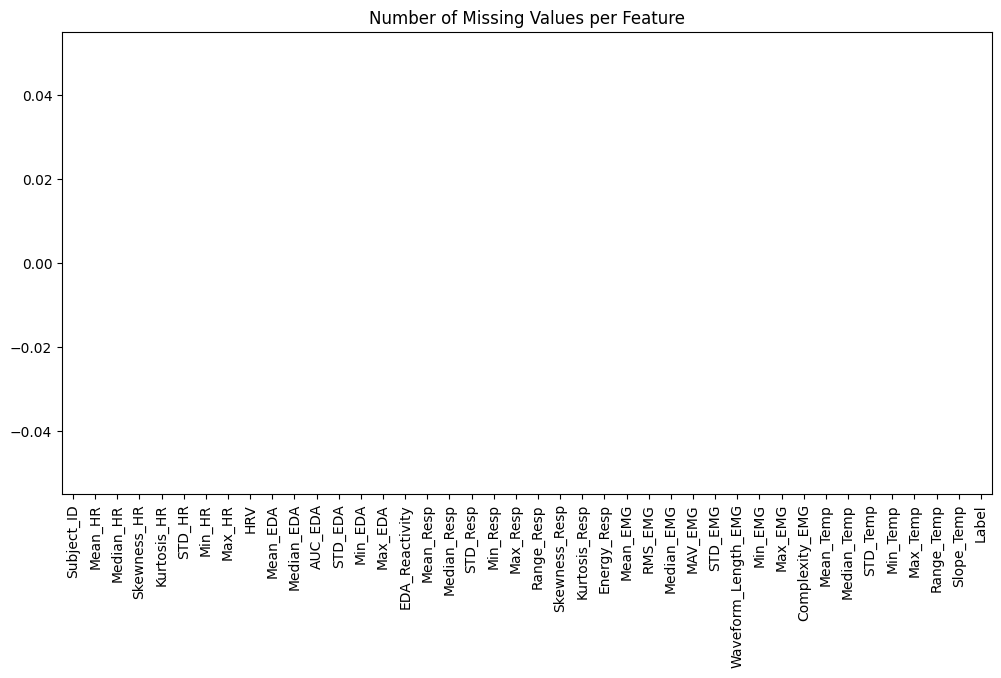

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

missing_values = wesad_features.isnull().sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.title('Number of Missing Values per Feature')
plt.show()

## Classes Balance Check

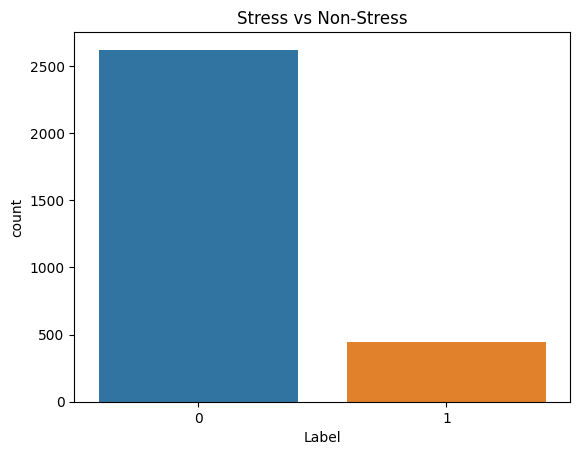

In [13]:
sns.countplot(x='Label', data=wesad_features)
plt.title('Stress vs Non-Stress')
plt.show()

## Correlation Check

In [14]:
corr_matrix = wesad_features.corr(numeric_only=True)

label_corr = corr_matrix['Label'].sort_values(ascending=False)
print(label_corr)

Label                  1.000000
Skewness_Resp          0.279771
Max_HR                 0.268721
STD_HR                 0.265488
HRV                    0.242026
Max_Resp               0.234936
Range_Resp             0.144846
STD_Resp               0.138738
Mean_HR                0.129919
EDA_Reactivity         0.120530
Max_EDA                0.115553
Kurtosis_Resp          0.111148
AUC_EDA                0.110741
Mean_EDA               0.110741
Median_EDA             0.110696
Min_EDA                0.106347
STD_EDA                0.101406
Energy_Resp            0.087759
Median_HR              0.084769
Median_Temp            0.077100
Max_Temp               0.076819
Mean_Temp              0.076437
Min_EMG                0.066620
Complexity_EMG         0.057569
STD_Temp               0.043688
Range_Temp             0.043080
Mean_EMG               0.034925
Slope_Temp             0.031035
Median_EMG             0.021699
Mean_Resp             -0.010181
Min_Temp              -0.026942
Min_Resp

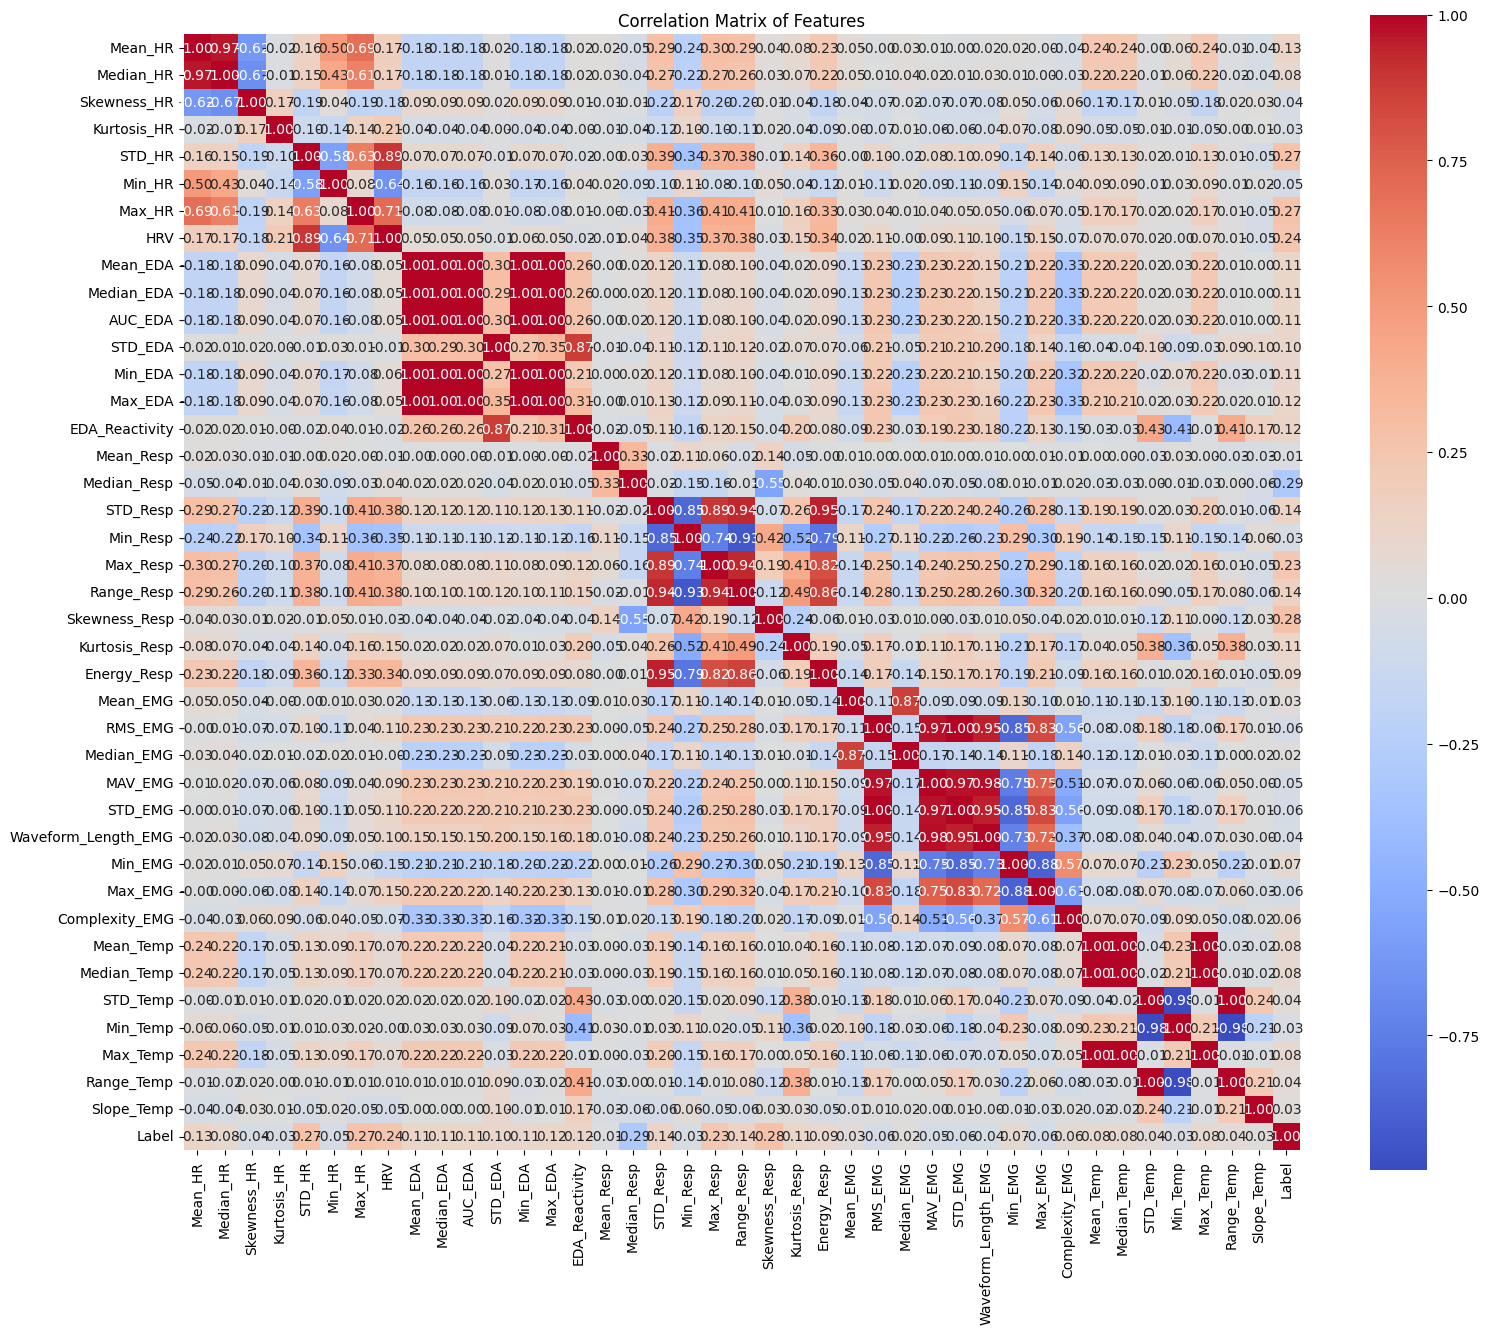

In [15]:
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.show()

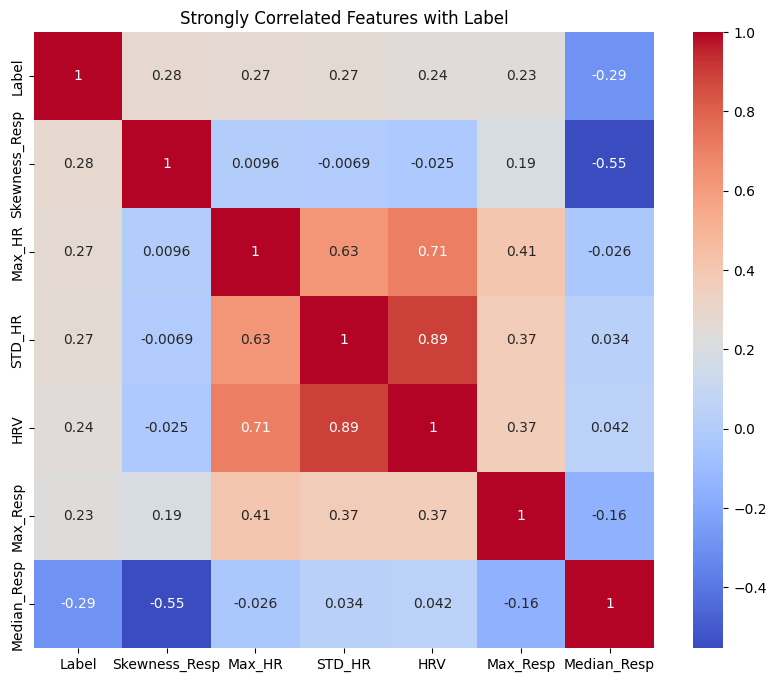

In [16]:
strong_corr = label_corr[abs(label_corr) > 0.2].index

plt.figure(figsize=(10, 8))
sns.heatmap(wesad_features[strong_corr].corr(), annot=True, cmap='coolwarm')
plt.title("Strongly Correlated Features with Label")
plt.show()

# RandomForestClassifier Model

## Separate between Features and Labels

In [17]:
X = wesad_features.drop(columns=["Label", "Subject_ID"])
Y = wesad_features["Label"]

## Using RandomForest to Select Best Features

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [19]:
model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [20]:
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

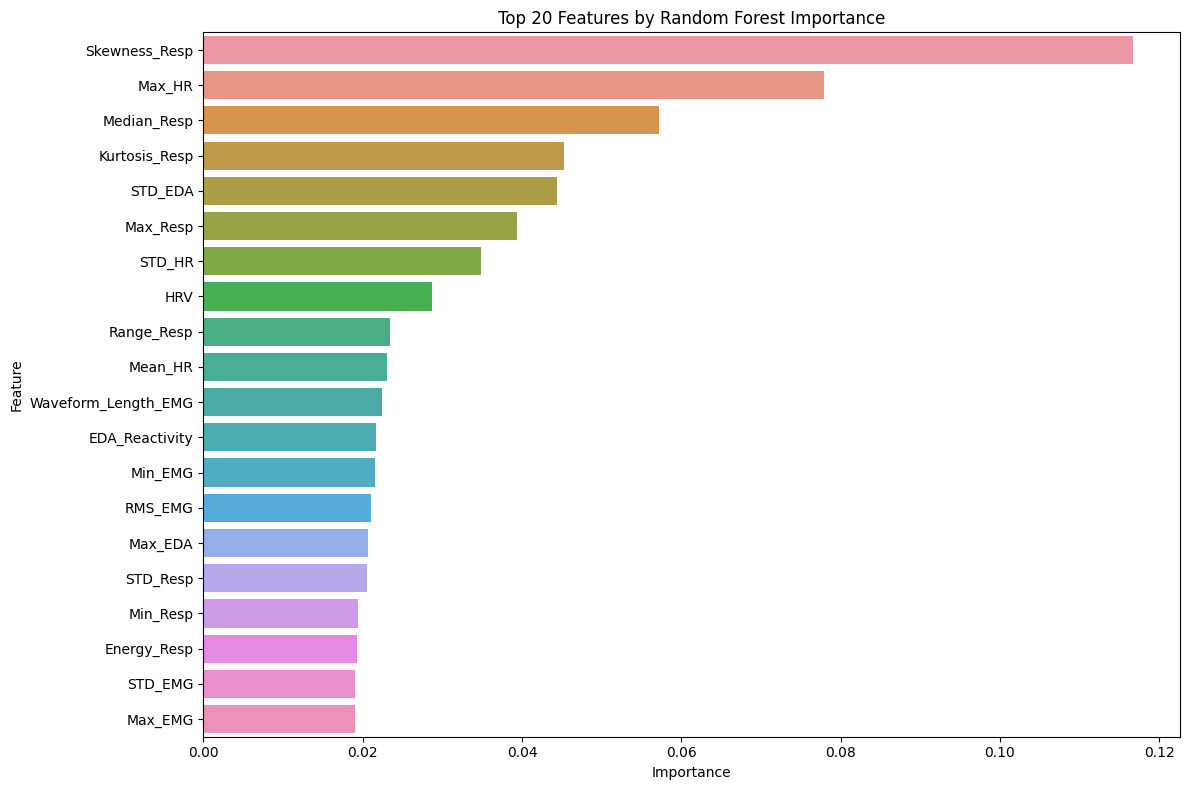

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

In [22]:
top_features = importance_df.head(20)['Feature'].values
X_top = wesad_features[top_features]

In [23]:
X_top

,Skewness_Resp,Max_HR,Median_Resp,Kurtosis_Resp,STD_EDA,Max_Resp,STD_HR,HRV,Range_Resp,Mean_HR,Waveform_Length_EMG,EDA_Reactivity,Min_EMG,RMS_EMG,Max_EDA,STD_Resp,Min_Resp,Energy_Resp,STD_EMG,Max_EMG
0,0.283574,85.714286,-0.274658,-0.549261,0.325917,4.624939,6.747035,24.844720,8.914185,72.440916,164.175659,1.570129,-0.088486,0.011538,6.488419,1.845889,-4.289246,71557.554035,0.011227,0.069077
1,-0.002481,96.774194,0.117493,-0.007707,0.182887,8.067322,7.032595,28.922820,15.682983,81.667369,194.806000,0.873184,-0.109543,0.013972,5.966949,2.965047,-7.615662,184739.844955,0.013699,0.059143
2,0.211991,92.715232,0.320435,-0.465849,0.315461,7.417297,4.506365,22.598370,13.977051,78.333484,229.690475,1.499557,-0.113342,0.016153,6.514359,2.941725,-6.559753,184103.292639,0.015898,0.070496
3,0.053009,85.539715,-0.442505,-0.694261,0.262420,5.235291,4.480137,20.119154,12.170410,74.459089,230.316696,1.130676,-0.094254,0.015821,6.281662,2.638318,-6.935120,146663.699525,0.015558,0.068069
4,0.092747,85.365854,-0.320435,-0.610376,0.227589,5.657959,5.123314,24.319342,12.425232,73.160889,231.759476,0.996780,-0.088211,0.015826,6.021881,2.625896,-6.767273,144805.210202,0.015574,0.064636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,0.015353,86.597938,-0.407410,2.067405,0.010736,21.345520,8.437882,35.190349,38.963318,65.849341,178.689148,0.255203,-0.068893,0.011736,7.315445,6.444589,-17.617798,872281.345560,0.010949,0.071732
3059,0.606263,75.675676,-0.503540,-0.351300,0.008942,9.071350,6.151183,27.232769,13.967896,58.616536,200.733307,0.243759,-0.127213,0.012944,7.311630,3.116411,-4.896545,205497.417995,0.012237,0.159897
3060,0.669426,80.152672,-1.011658,-0.404805,0.010135,8.824158,8.128319,26.853179,14.787292,62.551014,244.055328,0.235367,-0.204391,0.017060,7.299423,3.229985,-5.963135,219217.309027,0.016527,0.206726
3061,1.013953,98.360656,-0.135803,2.838711,0.066700,22.709656,15.884773,45.926199,34.063721,70.963651,276.825714,0.280380,-0.255295,0.020431,7.451248,5.684646,-11.354065,687762.592905,0.019996,0.318375


## Splitting WESAD DataFrame into Train and Test (80/20)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_top, Y, test_size = 0.2, random_state = 42)

## Balancing The Train Dataset

In [25]:
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

## Fitting

In [26]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,                 
    max_features='sqrt',          
    class_weight='balanced',
    random_state=42
)


model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=400,
                       random_state=42)

## Test Evaluation

In [27]:
pred = model.predict(X_test)

# Classification Report
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       528
           1       0.72      0.86      0.78        85

    accuracy                           0.93       613
   macro avg       0.85      0.90      0.87       613
weighted avg       0.94      0.93      0.94       613



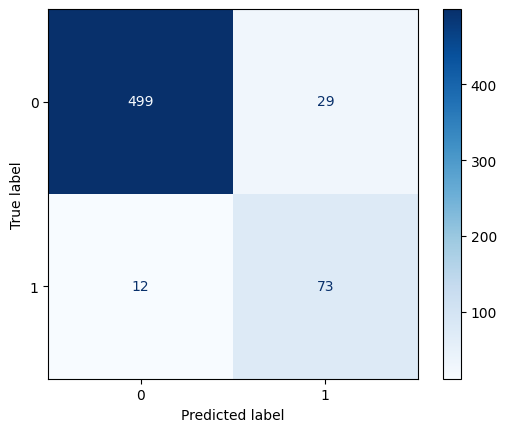

In [28]:
# Confusion Matrix
cm = confusion_matrix(Y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Train Evaluation

In [29]:
train_pred = model.predict(X_train)

# Classification Report
print(classification_report(Y_train, train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2092
           1       1.00      1.00      1.00      2092

    accuracy                           1.00      4184
   macro avg       1.00      1.00      1.00      4184
weighted avg       1.00      1.00      1.00      4184



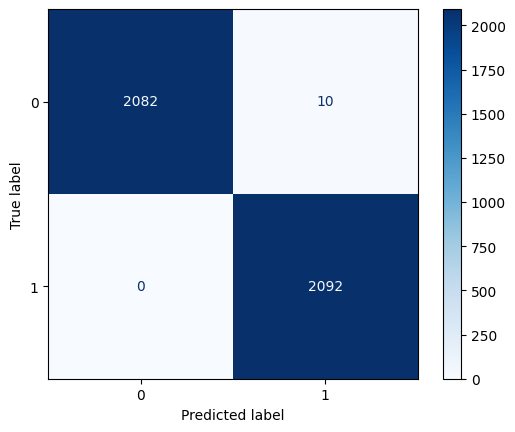

In [30]:
# Confusion Matrix
train_cm = confusion_matrix(Y_train, train_pred)

train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
train_disp.plot(cmap=plt.cm.Blues)
plt.show()

# Saving the model for deployment

In [31]:
import joblib

joblib.dump(model, 'stress_detection_model.pkl')

['stress_detection_model.pkl']